In [63]:
import pandas as pd
import scanpy as sc
import plotnine as p9

import liana as li
import cell2cell as c2c
import decoupler as dc # needed for pathway enrichment

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
# NOTE: to use CPU instead of GPU, set use_gpu = False
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        tl.set_backend('pytorch')
else:
    device = "cpu"

device

'cuda'

In [3]:
adata = sc.read_h5ad("/data/yypdata/NMF/Benchmark/cellphoneDB/Single_cell_atlas_COVID_sparse.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 44721 × 26361
    obs: 'Admission', 'ClusterID', 'DPS', 'DTF', 'Donor_full', 'HLA1', 'IFN1', 'Sex', 'Status', 'Ventilated', 'cell_type_coarse', 'cell_type_fine', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'percent_mt', 'percent_rpl', 'percent_rps', 'percent_rrna', 'seurat_clusters', 'singler'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance'
    uns: 'assay', 'authors', 'disease', 'organism', 'preprint', 'short_name', 'tissue'
    obsm: 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'
    layers: 'matrix', 'norm_data'

In [4]:
import scipy.io as sio

sio.mmwrite('/data/yypdata/NMF/Benchmark/cellphoneDB/multinichenet/data_matrix.mtx', adata.X)
adata.obs.to_csv('/data/yypdata/NMF/Benchmark/cellphoneDB/multinichenet/colData.csv')
adata.var.to_csv('/data/yypdata/NMF/Benchmark/cellphoneDB/multinichenet/rowData.csv')

In [5]:
adata.obs

,Admission,ClusterID,DPS,DTF,Donor_full,HLA1,IFN1,Sex,Status,Ventilated,...,nCount_RNA,nCount_SCT,nFeature_RNA,nFeature_SCT,percent_mt,percent_rpl,percent_rps,percent_rrna,seurat_clusters,singler
covid_555_1.1,ICU,13,9,9,C1 A,-0.026053,0.015625,M,COVID,NonVent,...,1222.0,1682.0,125,126,1.309329,0.245499,0.081833,46.644844,12,Erythroblast
covid_555_1.2,ICU,10,9,9,C1 A,0.023525,-0.000322,M,COVID,NonVent,...,1099.0,1700.0,160,160,13.102820,0.363967,0.363967,58.780708,9,B_cell
covid_555_1.3,ICU,19,9,9,C1 A,-0.044271,0.086385,M,COVID,NonVent,...,1055.0,1661.0,212,213,2.938389,0.947867,0.663507,55.829384,18,B_cell
covid_555_1.7,ICU,10,9,9,C1 A,-0.038040,0.022590,M,COVID,NonVent,...,2411.0,1971.0,312,312,10.908337,0.165906,0.041477,67.399422,9,B_cell
covid_555_1.8,ICU,22,9,9,C1 A,-0.043605,0.010739,M,COVID,NonVent,...,2276.0,1948.0,336,336,11.203866,0.307557,0.263620,67.355011,21,B_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HIP045.2543,N/A,7,0,0,H6,0.588374,0.092001,M,Healthy,Healthy,...,6103.0,1959.0,2460,1080,6.898247,3.637555,2.867442,10.797968,6,Monocyte
HIP045.2544,N/A,21,0,0,H6,1.295145,0.045697,M,Healthy,Healthy,...,7324.0,2088.0,2488,1031,6.485527,6.157837,4.929000,12.738940,20,Monocyte
HIP045.2545,N/A,21,0,0,H6,0.892457,0.062819,M,Healthy,Healthy,...,6368.0,1929.0,2511,1021,4.742462,6.171483,4.978015,14.400126,20,T_cells
HIP045.2546,N/A,11,0,0,H6,0.020954,0.036953,M,Healthy,Healthy,...,6669.0,1918.0,2650,1063,4.573400,3.328835,2.998950,14.574899,10,Monocyte


In [6]:
#adata.obs['sample'] = adata.obs.index
sample_key = 'Donor_full'
condition_key = 'Status'
groupby = 'cell_type_coarse'

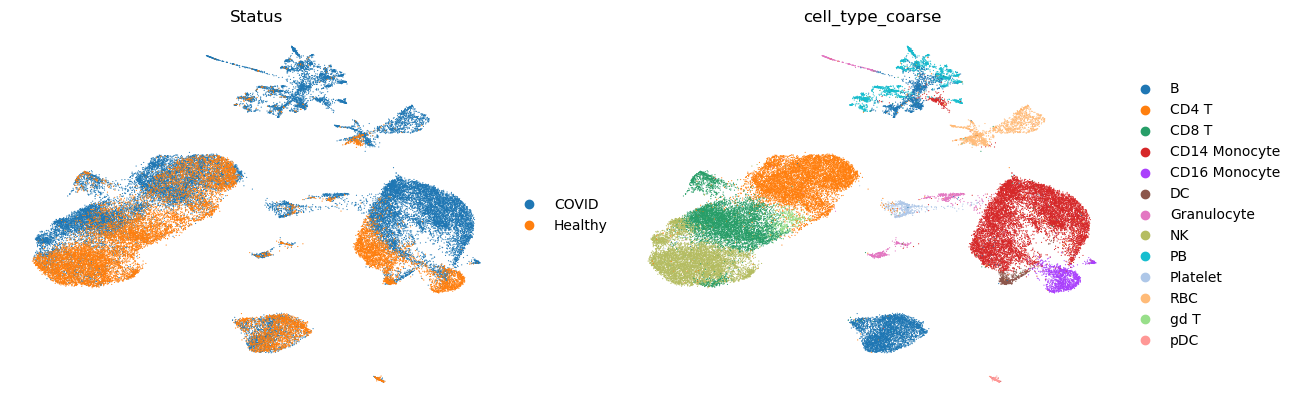

In [7]:
sc.pl.umap(adata, color=[condition_key, groupby], frameon=False)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    resource_name='consensus', # NOTE: uses human gene symbols!
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all verbose information
    n_perms=None, # exclude permutations for speed
    return_all_lrs=True, # return all LR values
    )

Now running: H6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [04:17<00:00, 18.36s/it]


In [10]:
adata.uns["liana_res"].sort_values("magnitude_rank").head(10)

,Donor_full,source,target,ligand_complex,receptor_complex,lr_means,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank
1275559,C3,CD14 Monocyte,CD16 Monocyte,S100A9,ITGB2,2.628223,5.622974,1.612743,2.743658,0.057586,0.985265,9.063944e-11
493344,C1 B,Granulocyte,CD14 Monocyte,S100A8,ITGB2,2.764429,6.839326,1.114002,1.909819,0.047826,0.986757,9.385256e-11
3071926,C7,CD14 Monocyte,CD14 Monocyte,S100A9,ITGB2,2.249927,4.436984,0.480522,1.540488,0.037898,0.984733,9.484812e-11
3675087,H1,Platelet,Platelet,TLN1,ITGB3,1.880793,3.483611,7.504384,2.796051,0.198202,0.980308,1.169049e-10
5615686,H5,pDC,DC,APP,CD74,2.167222,3.647486,3.496546,2.152385,0.108317,0.981023,1.291955e-10
1890381,C4,CD14 Monocyte,CD14 Monocyte,S100A9,ITGB2,2.385098,5.370717,1.389610,2.263727,0.059263,0.986401,1.387990e-10
0,C1 A,CD14 Monocyte,CD14 Monocyte,S100A9,ITGB2,2.372056,5.334261,0.778737,2.168056,0.034443,0.985619,1.394099e-10
4631647,H3,pDC,DC,APP,CD74,2.269855,4.341690,4.321332,2.387592,0.132005,0.979954,1.424484e-10
6130798,H6,pDC,DC,APP,CD74,2.033698,3.109984,3.833662,2.370938,0.134255,0.981317,1.912943e-10
4213183,H2,pDC,DC,APP,CD74,2.324361,4.386014,3.348074,2.171117,0.127178,0.979556,1.935381e-10


In [11]:
tensor = li.multi.to_tensor_c2c(adata,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [08:47<00:00, 37.67s/it]


In [12]:
tensor.tensor.shape

torch.Size([14, 1705, 13, 13])

In [13]:
c2c.io.export_variable_with_pickle(tensor, "/data/yypdata/NMF/Benchmark/tensor_c2c/tensor_tutorial.pkl")

/data/yypdata/NMF/Benchmark/tensor_c2c/tensor_tutorial.pkl  was correctly saved.


In [ ]:
tensor = c2c.io.read_data.load_tensor("/data/yypdata/NMF/Benchmark/tensor_c2c/tensor_tutorial.pkl")

In [14]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

In [16]:
c2c.io.export_variable_with_pickle(variable=tensor_meta, filename = '/data/yypdata/NMF/Benchmark/tensor_c2c/Tensor-Metadata.pkl')

/data/yypdata/NMF/Benchmark/tensor_c2c/Tensor-Metadata.pkl  was correctly saved.


In [ ]:
tensor_meta = c2c.io.load_variable_with_pickle('/data/yypdata/NMF/Benchmark/tensor_c2c/Tensor-Metadata.pkl/Tensor-Metadata.pkl')

In [17]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device=device, # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

Running Tensor Factorization


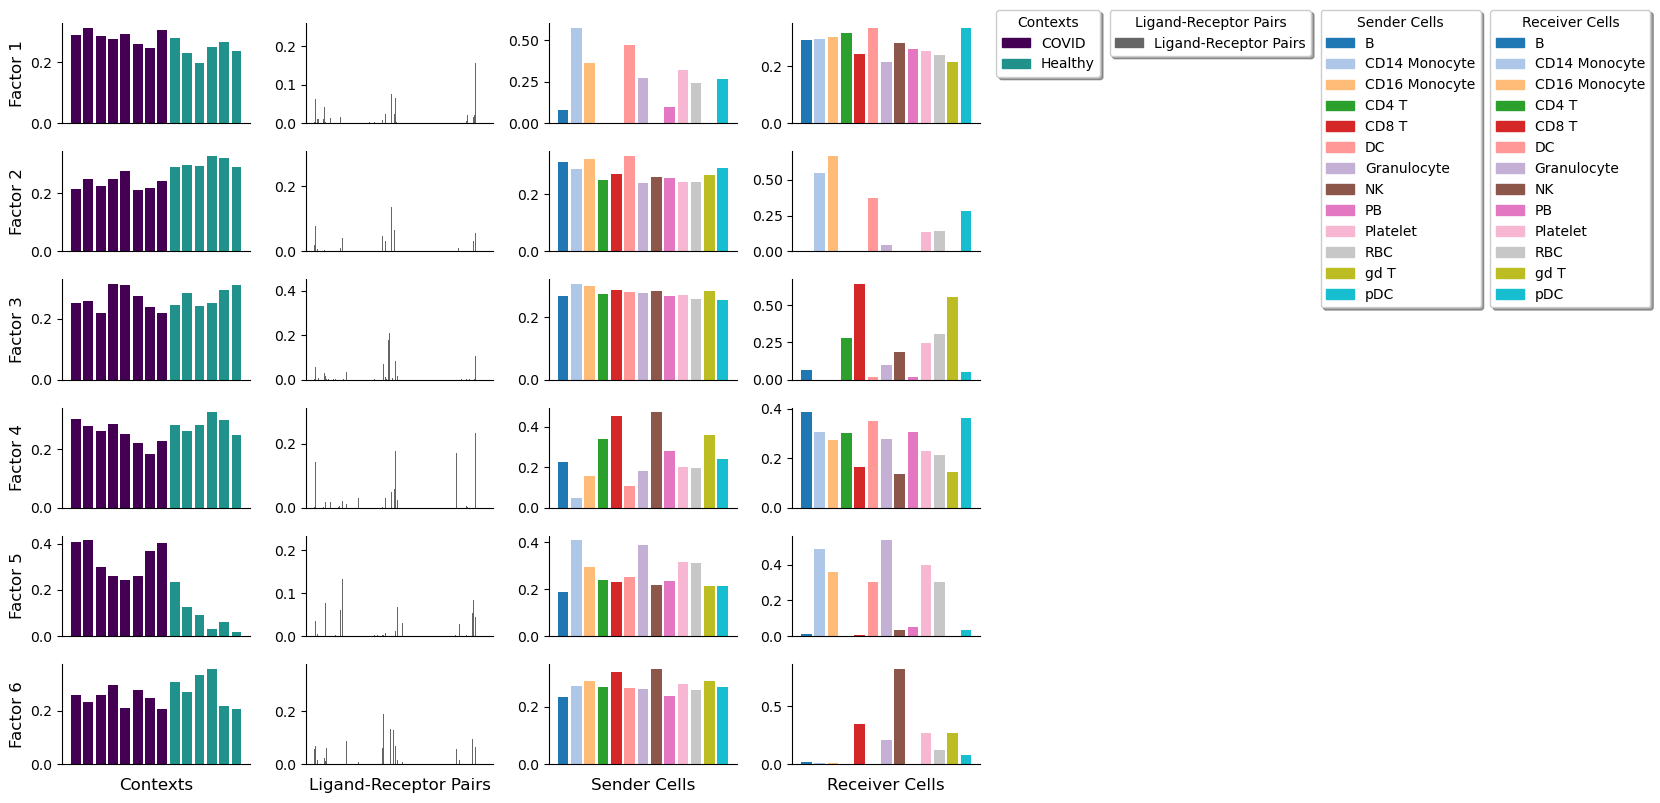

In [62]:
#import matplotlib.pyplot as plt
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/factor.png',bbox_inches='tight')

In [66]:
factors = tensor.factors

In [67]:
factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

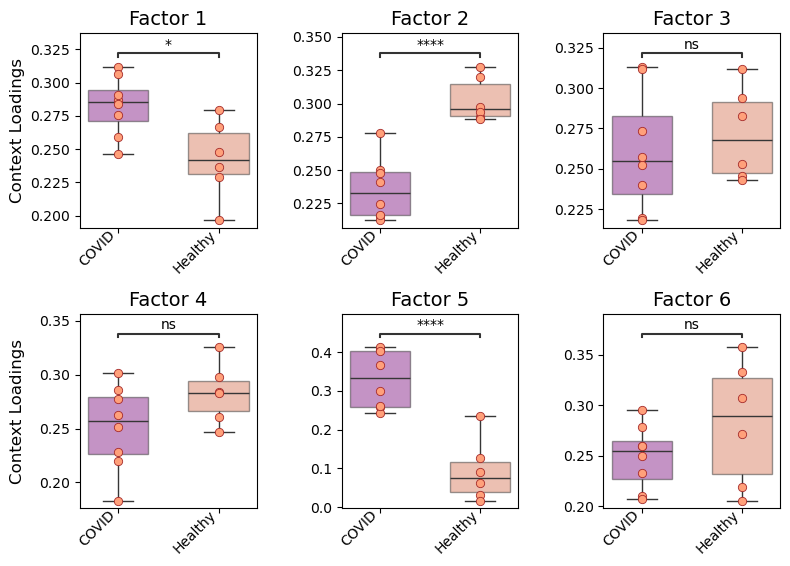

In [68]:
plot = c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=2,
                                 figsize=(8, 6),
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap='plasma',
                                 verbose=False,
                                )
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/difference.png',bbox_inches='tight')

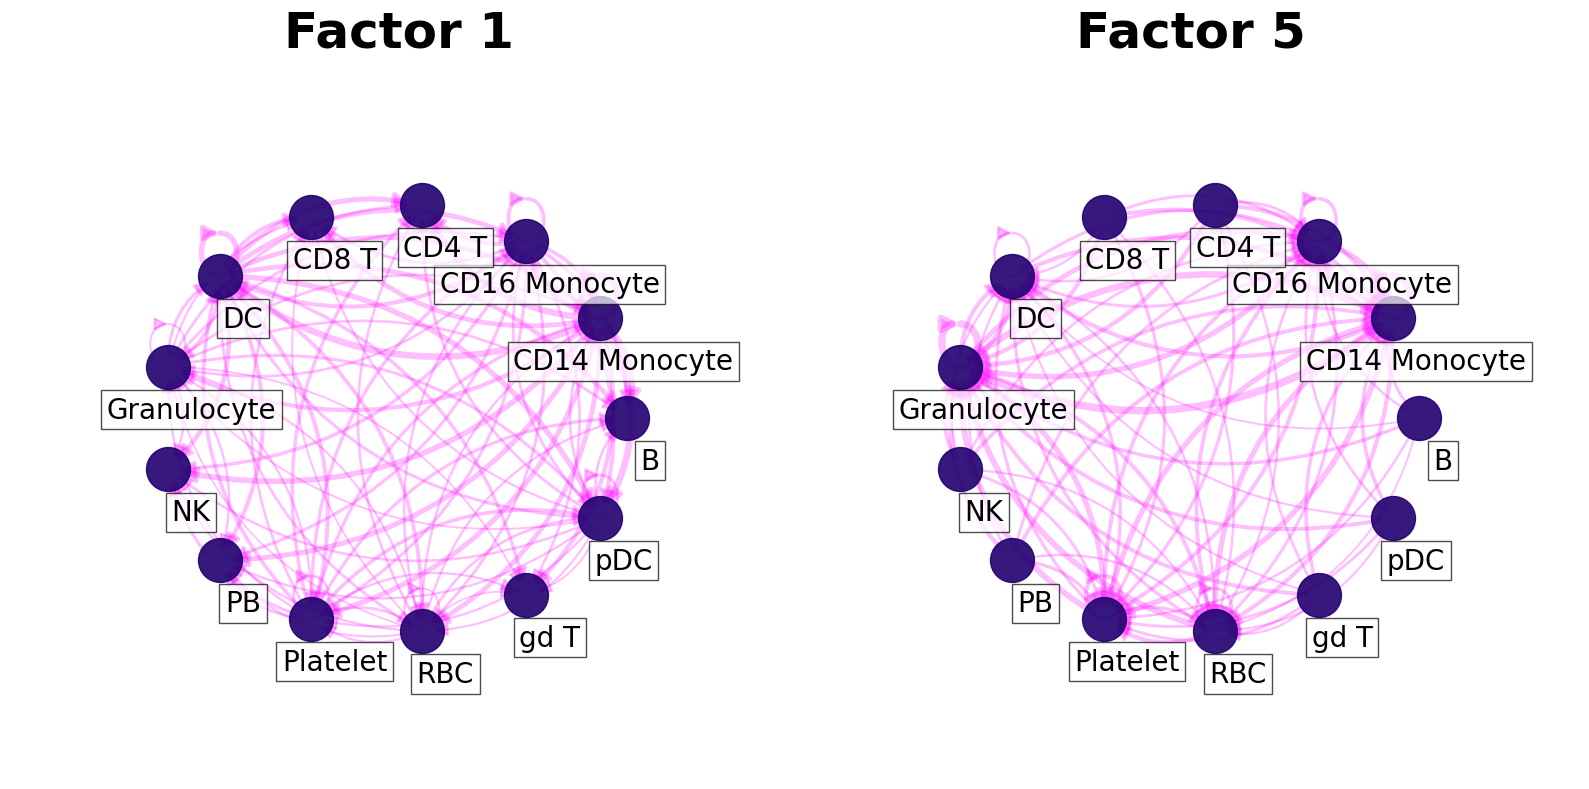

In [28]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 1','Factor 5'],
                               network_layout='circular',
                               ccc_threshold=0.05, # Only important communication
                               nrows=1,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )
plt.show()

In [29]:
lr_loadings = factors['Ligand-Receptor Pairs']

In [43]:
list1 = lr_loadings.sort_values("Factor 1", ascending=False).head(25).index.tolist() + lr_loadings.sort_values("Factor 5", ascending=False).head(25).index.tolist()

In [44]:
df = pd.DataFrame({'Column1': list1})

In [49]:
df.to_csv('/data/yypdata/NMF/Benchmark/tensor_c2c/tensorc2c.csv')

In [46]:
lr_loadings.sort_values("Factor 1", ascending=False).head(10)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
S100A9^ITGB2,0.247735,3.002852e-02,0.096663,2.243924e-03,0.216967,2.230159e-02
S100A8^ITGB2,0.230302,1.487168e-02,0.087068,4.376715e-06,0.212660,4.777255e-03
VCAN^ITGA4,0.213503,1.471784e-03,0.042446,1.833588e-05,0.056645,2.937787e-05
VCAN^CD44,0.212499,5.228309e-04,0.044259,2.118112e-06,0.086248,2.035056e-05
VCAN^SELL,0.209469,1.709299e-06,0.039266,2.151663e-06,0.101365,1.324857e-04
APP^CD74,0.205028,2.025363e-02,0.001972,1.162849e-02,0.001740,5.828192e-07
LGALS9^PTPRC,0.203284,4.730984e-03,0.049711,2.079282e-04,0.045899,3.415739e-03
VCAN^ITGB1,0.187731,3.504664e-04,0.044812,9.831370e-06,0.052148,7.263136e-04
GRN^TNFRSF1B,0.172092,5.828257e-02,0.063726,6.089594e-06,0.047449,4.375749e-03
CD14^ITGB2,0.161870,1.948658e-07,0.014774,6.732069e-16,0.079622,3.001052e-05


In [48]:
lr_loadings.sort_values("Factor 5", ascending=False).head(10)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
HLA-B^LILRB2,0.001782,0.291510,3.278676e-14,5.353966e-02,0.222512,7.191476e-05
S100A9^ITGB2,0.247735,0.030029,9.666311e-02,2.243924e-03,0.216967,2.230159e-02
S100A8^ITGB2,0.230302,0.014872,8.706776e-02,4.376715e-06,0.212660,4.777255e-03
S100A9^TLR4,0.010580,0.055097,3.585265e-20,3.222843e-12,0.204883,8.522846e-14
S100A9^CD36,0.054217,0.057852,3.122082e-15,1.654888e-05,0.204556,8.234231e-09
HLA-A^LILRB2,0.002308,0.202092,7.888231e-14,5.697631e-02,0.199530,1.301004e-04
S100A8^TLR4,0.011846,0.044087,6.790251e-21,4.489609e-15,0.193324,1.898320e-15
S100A8^CD36,0.053101,0.047120,7.129389e-16,1.125718e-06,0.192727,4.102405e-10
GNAI2^FPR1,0.001467,0.102993,2.346193e-10,1.994790e-02,0.187863,9.697584e-05
HLA-C^LILRB2,0.002463,0.199306,3.183118e-14,5.685157e-02,0.184458,1.599856e-04


In [32]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)

In [33]:
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [34]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
1,JAK-STAT,LGALS9^PTPRC,1.307807
32,JAK-STAT,LGALS9^CD47,2.054778
59,Trail,LGALS9^PTPRK,0.937003
68,JAK-STAT,LGALS9^HAVCR2,1.487678
79,EGFR,DLL1^NOTCH1,-1.000584


In [35]:
# run enrichment analysis
estimate, pvals = dc.run_ulm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

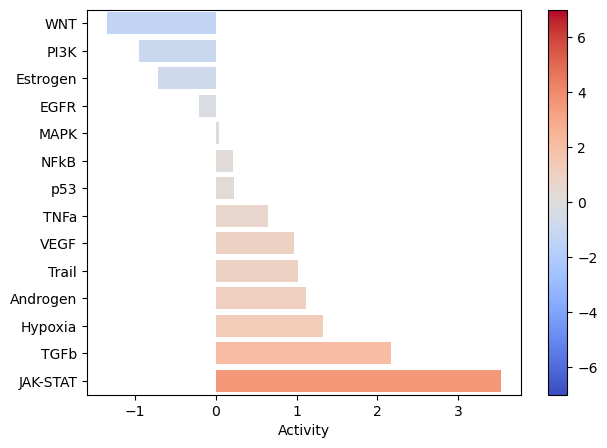

In [36]:
dc.plot_barplot(estimate, 'Factor 1', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/dc_factor1.png',bbox_inches='tight')
plt.show()

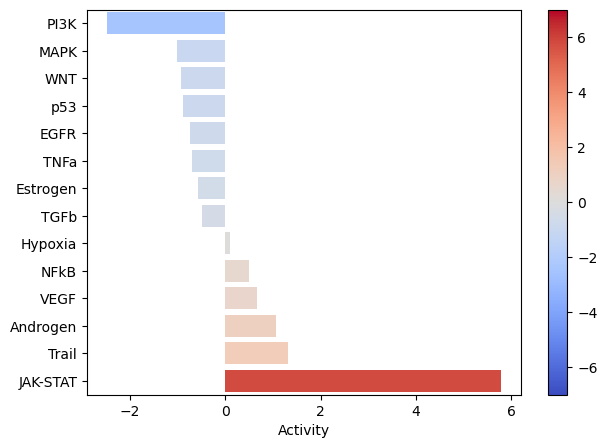

In [37]:
dc.plot_barplot(estimate, 'Factor 5', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/dc_factor5.png',bbox_inches='tight')
plt.show()

Chunk_H

In [50]:
lr=pd.read_csv("/data/yypdata/NMF/Benchmark/Chunk/Human-2020-Cabello-Aguilar-LR-pairs.csv")[['ligand','receptor']]
H = pd.read_csv("/data/yypdata/NMF/Benchmark/Chunk/Chunk_H.csv",index_col=0)

In [51]:
lr_progeny2 = li.rs.generate_lr_geneset(lr, net, lr_sep="-")

In [52]:
lr_progeny2

,source,interaction,weight
20,WNT,ACE-AGTR2,0.194430
51,EGFR,ACTR2-LDLR,1.132691
132,WNT,ADAM12-ITGA9,0.511125
133,Androgen,ADAM12-ITGB1,-0.676557
152,TGFb,ADAM12-ITGB1,2.152959
...,...,...,...
41675,Estrogen,WNT7B-FZD4,-2.320505
41684,WNT,WNT7B-FZD4,-0.613009
41690,Estrogen,WNT2B-FZD4,-1.757753
41707,TNFa,WNT2B-FZD4,-1.115577


In [53]:
lr_progeny2.duplicated(['source', 'interaction']).sum()
lr_progeny2 = lr_progeny2.drop_duplicates(subset=['source', 'interaction'], keep='first')

In [54]:
H

,ACTR2-ADRB2,ACTR2-LDLR,ADAM15-ITGA5,ADAM15-ITGAV,ADAM15-ITGB1,ADAM15-ITGB3,ADAM17-ITGA5,ADAM17-ITGB1,ADAM17-NOTCH1,ADAM28-ITGA4,...,CD1D-LILRB2,HLA-F-KIR3DL2,HLA-F-LILRB1,HLA-F-LILRB2,CD177-PECAM1,KLRB1-CLEC2D,CLEC2B-KLRF1,CD47-SIRPG,CD52-SIGLEC10,CD200-CD200R1
0,0.818087,0.621727,0.621041,0.237441,0.586166,0.358197,0.770169,0.724425,0.526548,0.092640,...,0.834889,0.000000,0.704255,1.177768,1.758138,0.229438,0.587090,0.244378,1.287384,0.000000
1,0.971493,0.639732,0.716888,0.473399,0.925907,0.485044,0.428889,0.589104,0.318017,0.875760,...,0.724963,0.170217,0.767691,0.976920,0.129613,1.146741,0.727858,1.168316,1.900576,0.723391
2,0.371410,0.037894,0.610140,0.025954,0.448337,0.381155,0.080184,0.000000,0.037255,0.000000,...,0.672322,0.227094,0.687540,0.906091,0.558443,0.453481,0.592226,0.416717,0.796509,0.000000
3,0.770138,1.111025,0.572160,0.588004,0.871508,1.185459,1.721386,2.036820,1.326941,0.893837,...,0.350163,0.000000,0.172614,0.816600,0.747997,1.055030,0.831774,0.815706,0.579854,0.845443
4,0.522278,0.734524,0.365314,0.458647,0.270476,0.411621,0.789956,0.713901,0.670413,0.384306,...,0.570371,0.571458,1.082631,0.693761,0.042956,0.513500,1.045839,0.615796,0.219921,0.000000
5,0.976431,0.392303,0.830013,0.750556,0.469364,0.258534,1.515238,1.171276,1.394009,0.791368,...,1.208202,0.179258,1.197016,0.893076,0.043220,0.163739,0.164540,0.166493,0.346297,0.002297
6,0.288591,0.404057,0.627328,0.171431,0.663342,0.581391,0.000375,0.012784,0.000000,0.000000,...,0.386986,0.159208,0.390636,0.655817,1.032838,0.033325,0.149277,0.188039,0.880882,0.000000
7,1.001960,0.081198,0.413472,0.118010,0.519512,0.126456,0.454804,0.519835,0.312098,0.292772,...,0.675129,3.227039,0.588094,1.026348,0.637591,1.646911,3.049494,0.692552,0.856885,0.000000
8,0.061572,0.185396,0.289532,0.000000,0.279026,0.565247,0.371300,0.367080,0.283103,0.000000,...,0.376009,0.097198,0.059452,0.545906,0.407815,0.208924,0.432107,0.112788,0.289098,0.000000
9,0.293277,0.461710,0.459689,0.307416,0.636626,0.571421,0.240622,0.397859,0.107249,0.256037,...,0.521320,0.147878,0.588112,0.433750,0.435861,0.226075,0.062761,0.202151,0.505194,0.133818


In [55]:
# run enrichment analysis
estimate2, pvals2 = dc.run_ulm(H, lr_progeny2, source="source", target="interaction", use_raw=False)

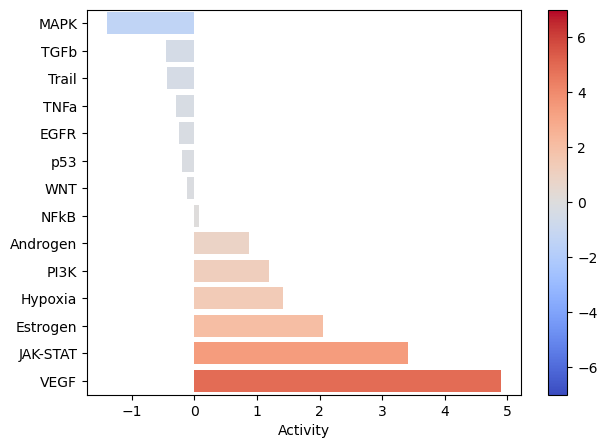

In [56]:
dc.plot_barplot(estimate2, '4', vertical=True, cmap='coolwarm', vmin=-7, vmax=7) # 4 5 7 8
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/Chunk_dc_factor4.png',bbox_inches='tight')
plt.show()

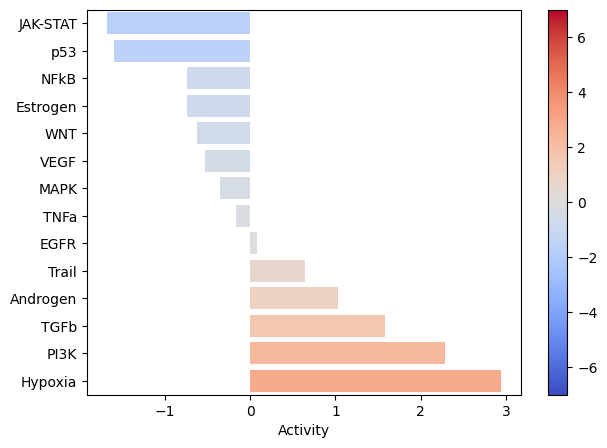

In [57]:
dc.plot_barplot(estimate2, '5', vertical=True, cmap='coolwarm', vmin=-7, vmax=7) # 4 5 7 8
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/Chunk_dc_factor5.png',bbox_inches='tight')
plt.show()

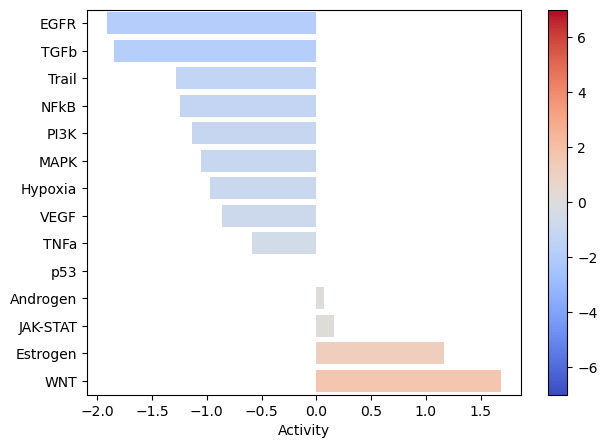

In [58]:
dc.plot_barplot(estimate2, '7', vertical=True, cmap='coolwarm', vmin=-7, vmax=7) # 4 5 7 8
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/Chunk_dc_factor7.png',bbox_inches='tight')
plt.show()

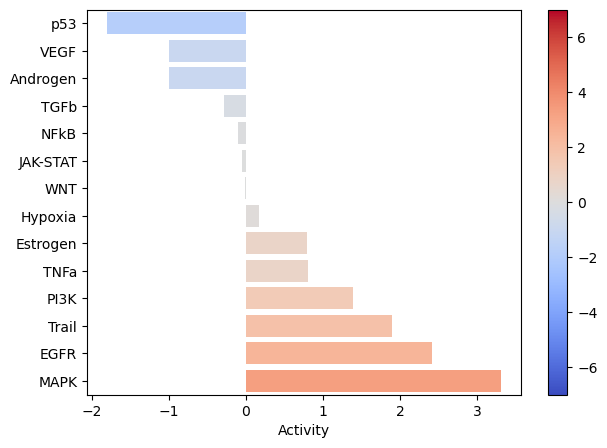

In [59]:
dc.plot_barplot(estimate2, '8', vertical=True, cmap='coolwarm', vmin=-7, vmax=7) # 4 5 7 8
plt.savefig('/data/yypdata/NMF/Benchmark/tensor_c2c/Chunk_dc_factor8.png',bbox_inches='tight')
plt.show()